<a href="https://colab.research.google.com/github/Sandi-DeLaVega/Emotion-AI/blob/main/Emotion_AI_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*From Udemy Course: Modern Artificial Intelligence Masterclass: Build 6 Projects
# Understand the Problem Statement and Business Case
##Artificial Emotional Intelligence or Emotion AI is a branch that allows computers to understand human non-verbal cues such as body language and facial expressions.
Affectiva offers cutting edge emotion AI tech:
https://www.affectiva.com/



#Project Overview
The aim of this project is to classify people's emotions based on their face images.
Working as an AI/ML consultat, train and deploy a system that automatically monitors people emotions and expressions.
The team collected more than 20000 facial images, with their associated facial expression labels and around 2000 images with their facial  key-point annotations.

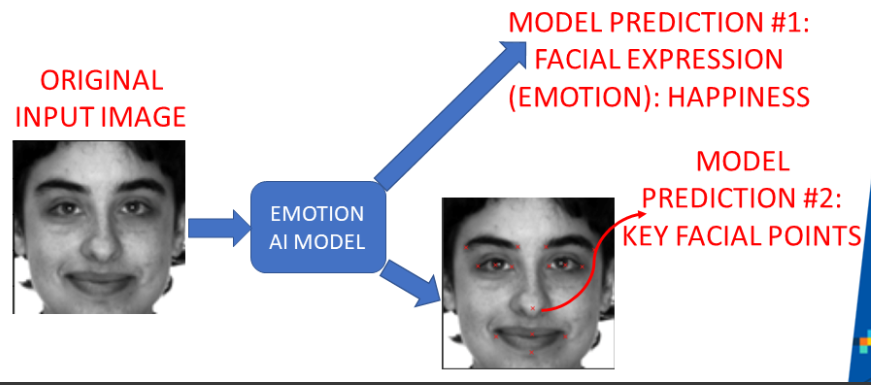

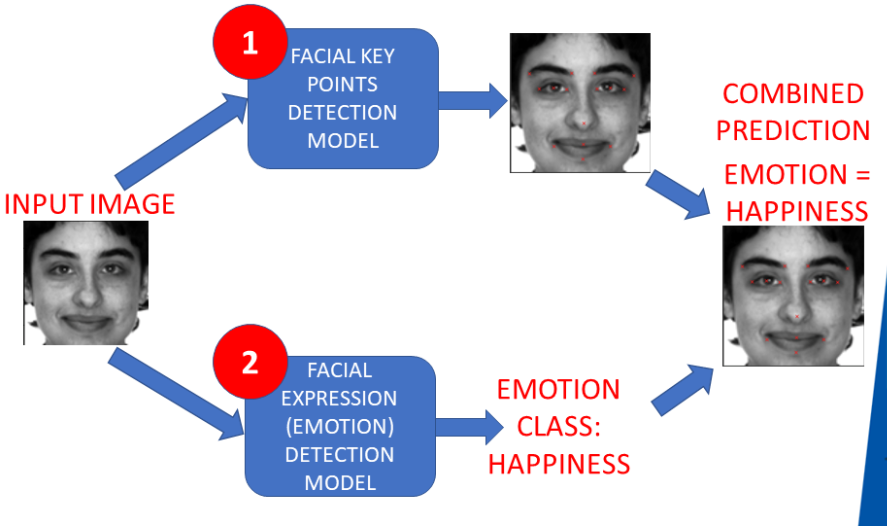

#Part 1 Key Facial Points Detection
#####Creating a Deep Learning Model Based on Convolutional Neural Network and Residual Blocks to predict facial key-points
The dataset consists of x and y coordinates of 15 facial key points.
Input images are 96x96 pixels
Images consists of only one color channel (gray-scale images).

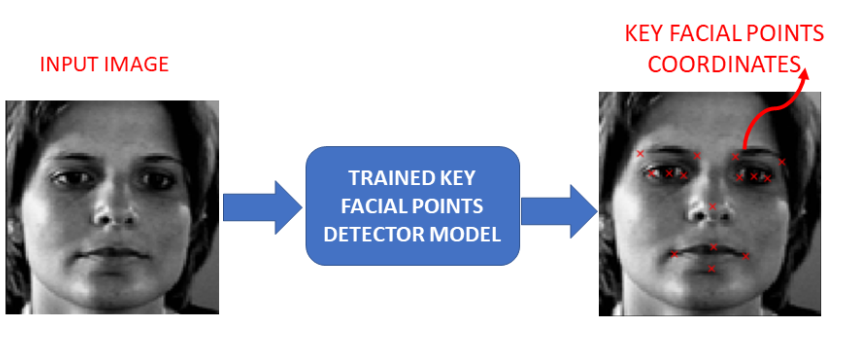

##Import Libraries and DataSets

In [1]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/EmotionAI_dataset/

/content/drive/My Drive/EmotionAI_dataset


In [3]:
#import the necessary packages
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [4]:
#load facial key points data
keyfacial_df = pd.read_csv('/content/drive/My Drive/EmotionAI_dataset/data.csv')

In [5]:
keyfacial_df.head()

left_eye_center_x  ...                                              Image
0          66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1          64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...
2          65.057053  ...  144 142 159 180 188 188 184 180 167 132 84 59 ...
3          65.225739  ...  193 192 193 194 194 194 193 192 168 111 50 12 ...
4          66.725301  ...  147 148 160 196 215 214 216 217 219 220 206 18...

[5 rows x 31 columns]

In [6]:
#Obtain relevant information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [7]:
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [8]:
keyfacial_df['Image'].shape

(2140,)

In [9]:
#Since Valeus for the Image column  are given as space separated string, separate the values using ' ' as separator.
#Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape(96,96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96,96))

In [10]:
#Obtain the shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

###Obtain the average, minimum and maximum values for right_eye_center_x

In [11]:
keyfacial_df.describe()['right_eye_center_x']

count    2140.000000
mean       29.640269
std         2.051575
min        18.922611
25%        28.472224
50%        29.655440
75%        30.858673
max        42.495172
Name: right_eye_center_x, dtype: float64

## Perform Image Visualization

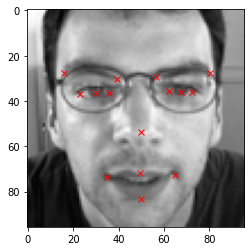

In [12]:
#Plot a random image from the dataset along with facial keypoints.
#Image data is obtained from df['Image] and plotted using plt.imshow
#15 x and y coordinates for the corresponding image
#since x-coordinates are in even columns like 0,2,4... and y - coordinates are in odd columns like 1,3,5,...
#we acces their value using .loc command, which get the values for coordinates of the image based on the column it is referring to.

#random picture
i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')

#from the random picture, place x marks on the critical points
for j in range(1,31,2):
  plt.plot(keyfacial_df.loc[i][j - 1], keyfacial_df.loc[i][j], 'rx')

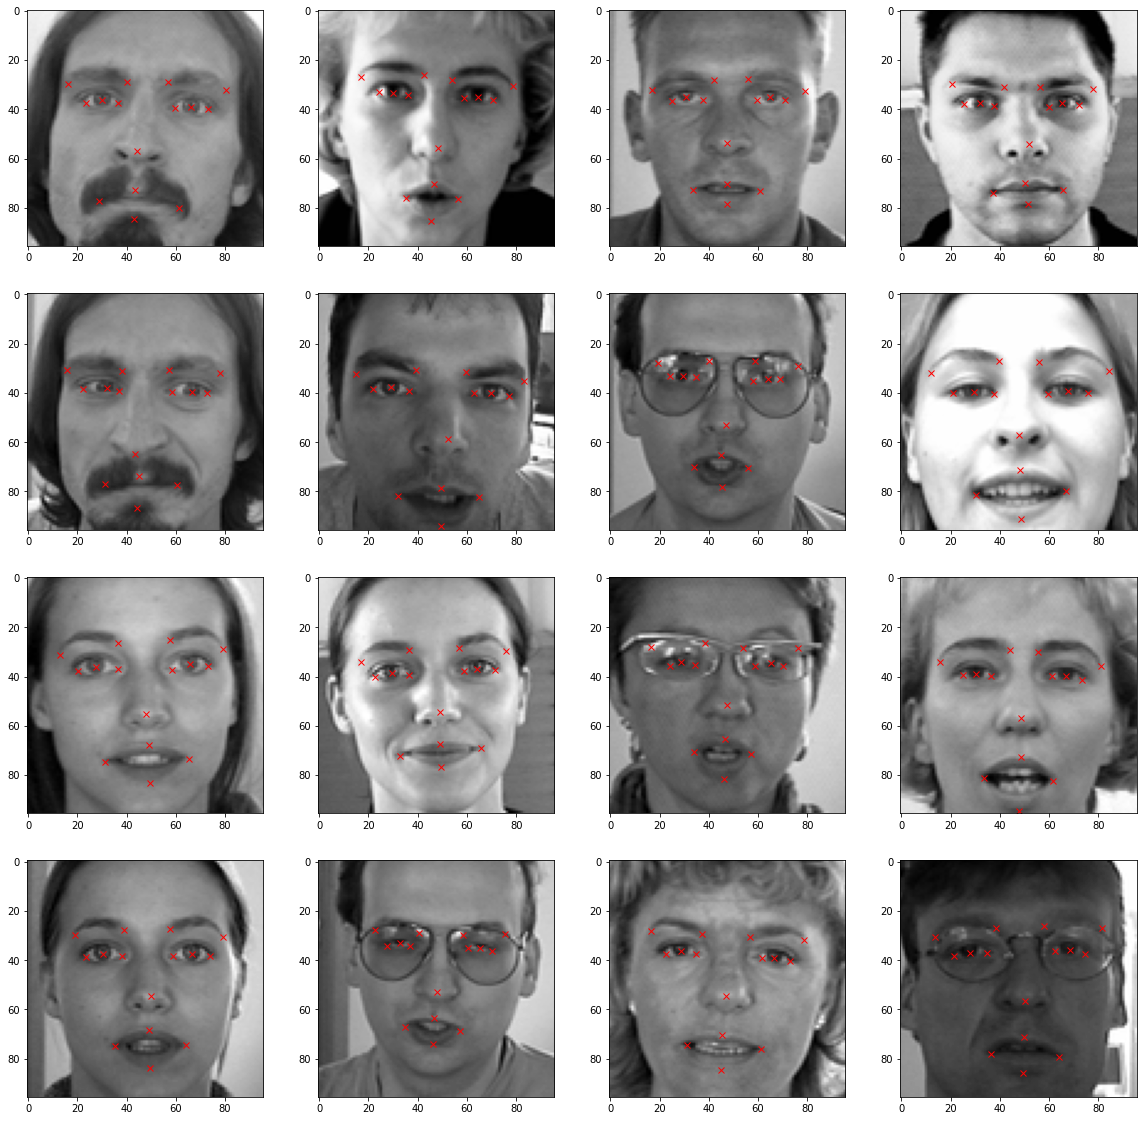

In [13]:
#View more images in a grid format
fig = plt.figure(figsize = (20,20))

for i in range(16):
  ax  = fig.add_subplot(4,4, i + 1)
  image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
  
  for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j],'rx')

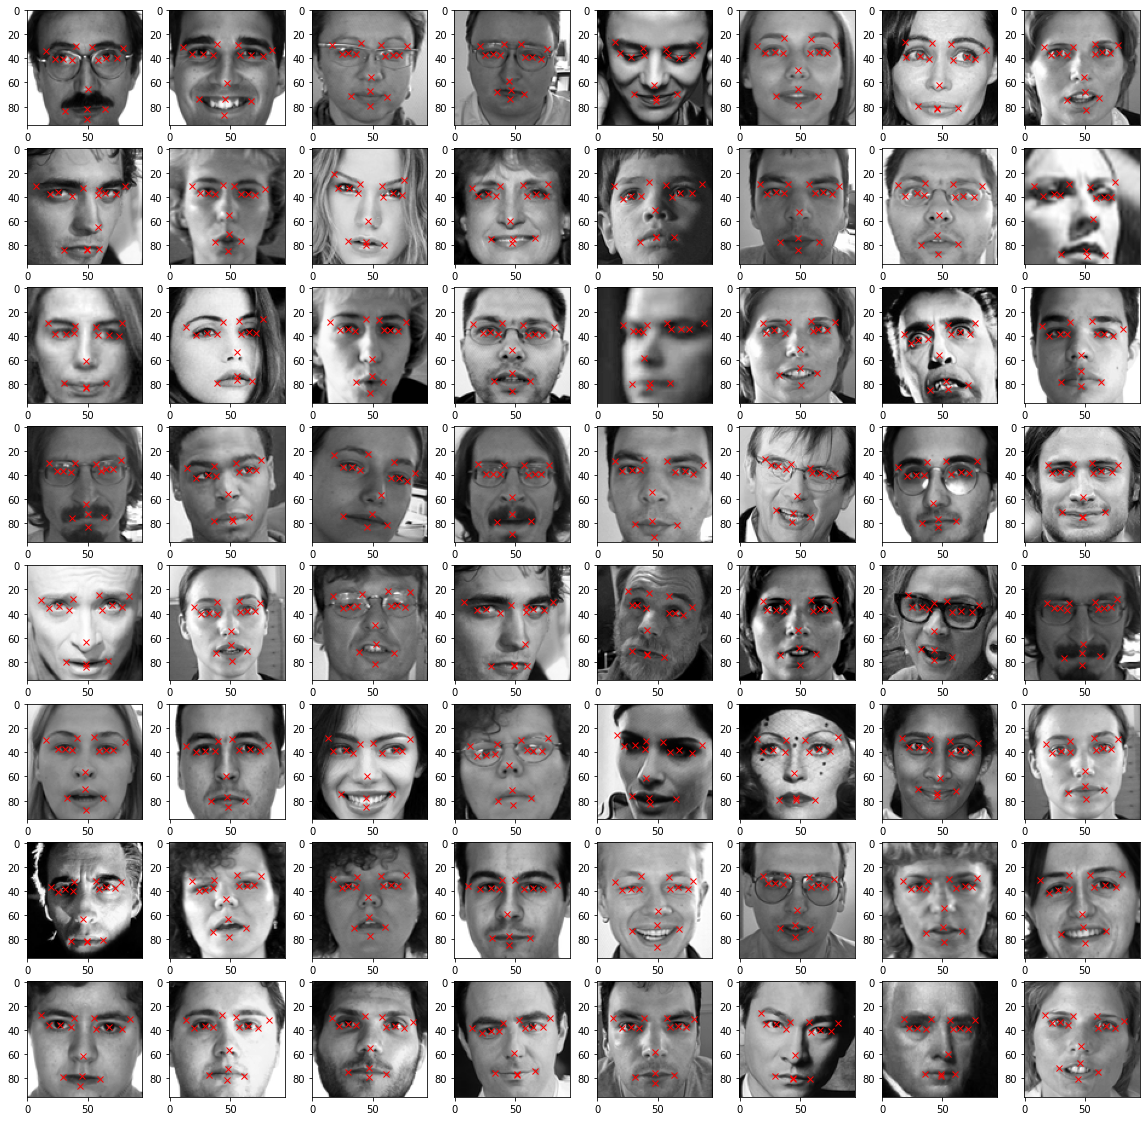

In [14]:
#Performing Sanity Check on the Data by Randomly Visualizing 64 new images along with their corresponding key points
import random
#view more images in grid format
fig = plt.figure(figsize = (20,20))

for i in range(64):
  k = random.randint(1, len(keyfacial_df))
  ax = fig.add_subplot(8,8, i + 1)
  image = plt.imshow(keyfacial_df['Image'][k], cmap = 'gray')

  for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j],'rx')

##Perform Image Augmentation

In [15]:
#Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [16]:
#Obtain the columns in the dataframe
columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [17]:
#Horizontal Flip - flip the images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

#since we are flipping horizontally, y coordinate values would be the same
#Only x coordinate values would change, all we have to do is to subtract our 
#initial x-coordinate values from width of image (96)
for i in range(len(columns)):
  if i % 2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

###Original Image

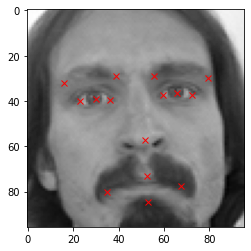

In [18]:

plt.imshow(keyfacial_df_copy['Image'][0] ,cmap = "gray")
for j in range(1,31,2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j],'rx')

###Horizontally Flipped Image

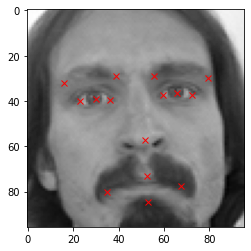

In [19]:
#Show the Horizontally Flipped Image
plt.imshow(keyfacial_df_copy['Image'][0], cmap = "gray")
for j in range(1,31,2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j],'rx')

In [20]:
#Concatenante the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))
augmented_df.shape

(4280, 31)

###Randomingly increasing the brightness of the image
###Multiply Pixel Values by Random Values between 1.5 and 2 to increase the brightness of the image
###Clip the Value between 0 and 255


In [21]:
import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.clip(random.uniform(1.5,2)*x,0.0,255.0))
augmented_df = np.concatenate((augmented_df,keyfacial_df_copy))
augmented_df.shape

(6420, 31)

### Show Image with Increased Brighness

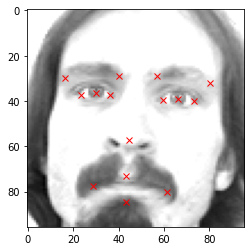

In [22]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

###Augmenting Images by Flipping Vertically


In [23]:
keyfacial_df_copy = copy.copy(keyfacial_df)

In [24]:
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(len(columns)):
  if i % 2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

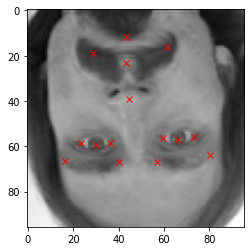

In [25]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1,31,2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j],'rx')

##Perform Data Normalization and Training Data Preparation

In [26]:
#Obtain the value of images in 31st column
img = augmented_df[:,30]

#Normalize the images
img = img/255.0

#Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

#Iterate through the img list and add image values to the empty array
#after expanding it's dimension from (96,96)
for i in range(len(img)):
  X[i, ] = np.expand_dims(img[i], axis = 2)

#Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [27]:
#Obtain the value of x & y coordinates which are to used as target
y = augmented_df[:,:30]

y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [28]:
#Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [29]:
X_train.shape

(5136, 96, 96, 1)

In [30]:
X_test.shape

(1284, 96, 96, 1)

##Build ResNet to Detect Key Facial Points

In [31]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [32]:
input_shape = (96, 96, 1)

#Input the tensor shape
X_input = Input(input_shape)

#Zero - padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

### Placing Stage 4

In [33]:
input_shape = (96, 96, 1)

#Input the tensor shape
X_input = Input(input_shape)

#Zero - padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

#Stage 4
X = res_block(X, filter= [256,256,1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

#### Before Placing Stage 4

- Total params: 18,016,286
- Trainable params: 18,007,710
- Non-trainable params: 8,576

#After Placing Stage 4
- Total params: 17,585,694
- Trainable params: 17,565,854
- Non-trainable params: 19,840

## Compile and Train Key Facial Points Detection Deep Learning Model

In [35]:
#Using Adam Optimizer
adam = keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam, metrics = ['accuracy'])


In [36]:
#Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [37]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 2, validation_split = 0.05, callbacks = [checkpointer])

Epoch 1/2
153/153 [==============================] - 171s 1s/step - loss: 732.6371 - accuracy: 0.3916 - val_loss: 793.2060 - val_accuracy: 0.6615

Epoch 00001: val_loss improved from inf to 793.20599, saving model to FacialKeyPoints_weights.hdf5
Epoch 2/2
153/153 [==============================] - 167s 1s/step - loss: 114.9767 - accuracy: 0.6198 - val_loss: 274.8722 - val_accuracy: 0.6615

Epoch 00002: val_loss improved from 793.20599 to 274.87219, saving model to FacialKeyPoints_weights.hdf5


In [38]:
#Save the model architecture to json file for future use
model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json", "w") as json_file:
  json_file.write(model_json)

##Assess Trained Key Facial Points Detection Model Performance

In [39]:
with open('detection.json', 'r') as json_file:
  json_savedModel = json_file.read()

#load the model architecture
model_1_facialKeyPoints = keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('weights_keypoint.hdf5')
adam = keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam, metrics = ["accuracy"])

In [40]:
#Evaluate the model
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy: {}".format(result[1]))

41/41 [==============================] - 7s 160ms/step - loss: 9.3508 - accuracy: 0.8337
Accuracy: 0.8426791429519653


In [41]:
#Get the model keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

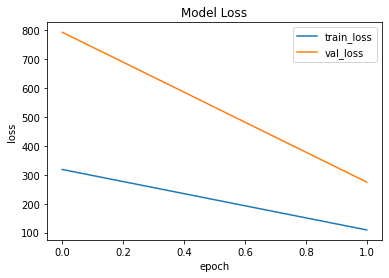

In [43]:
#Plot the training artifacts
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = "upper right")
plt.show()

#Part 2 Facial Expression Detection

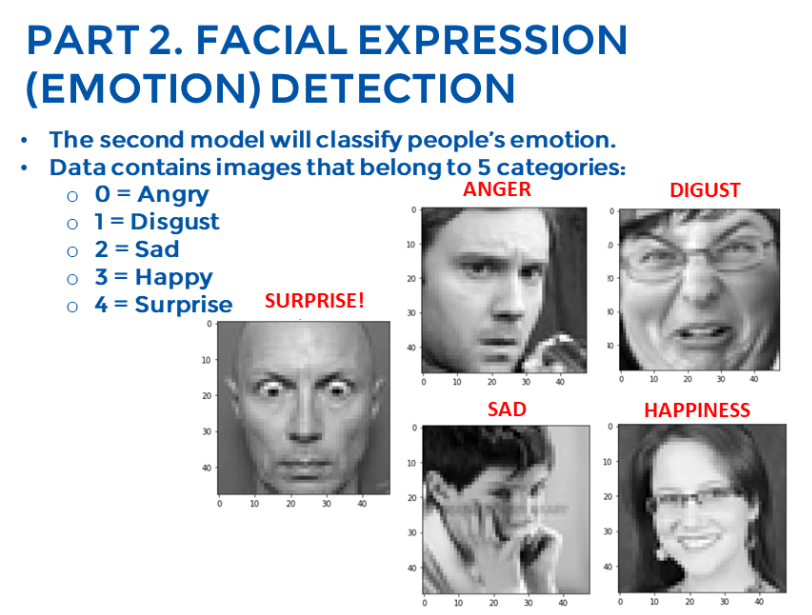

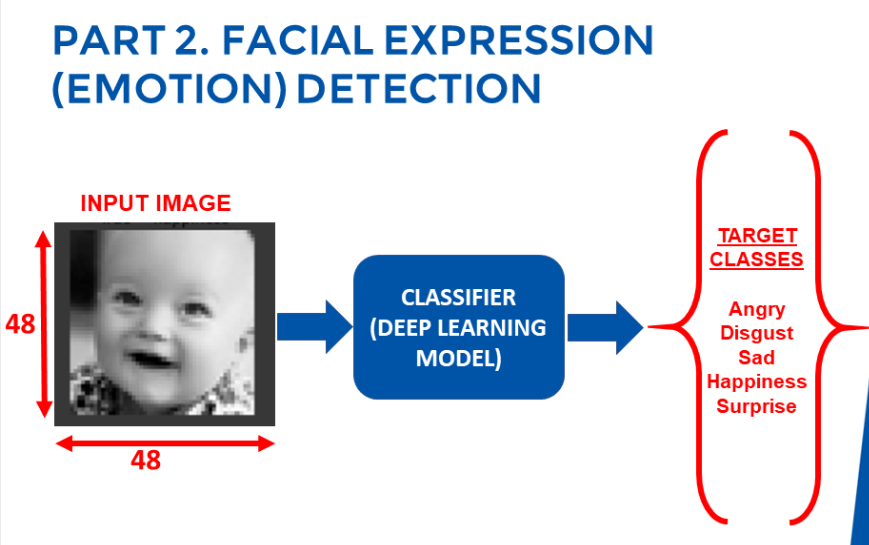

## Import and Explore DataSet for Facial Expression Detection

In [45]:
#read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [46]:
facialexpression_df

emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]

In [47]:
facialexpression_df[' pixels'][0] #String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [48]:
#function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [49]:
#Resize images from (48, 48) to (96, 96)
def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize= (96, 96), interpolation = cv2.INTER_CUBIC)

In [50]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [51]:
#Check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [52]:
#check the presence of null values in the dataframe
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [57]:
label_to_text = {0:'anger',
                 1: 'disgust',
                 2: 'sad',
                 3: 'happiness',
                 4: 'surprise'}

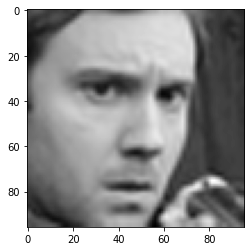

In [54]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

## Visualize Images and Plot Labels

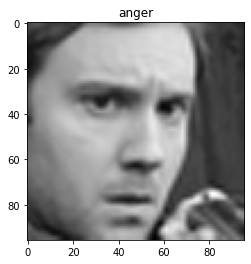

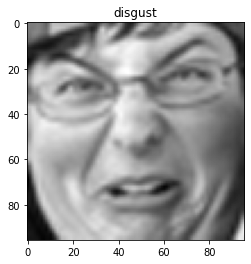

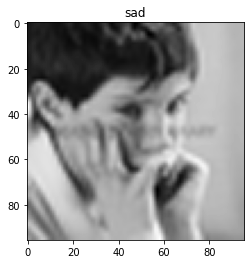

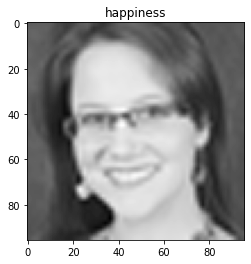

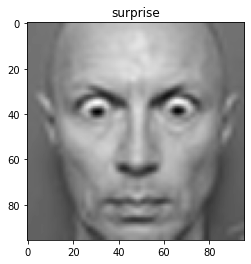

In [58]:
emotions = [0, 1, 2, 3, 4]
for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

###Plot bar chart to outline how many samples per Emotion

In [59]:
facialexpression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [60]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

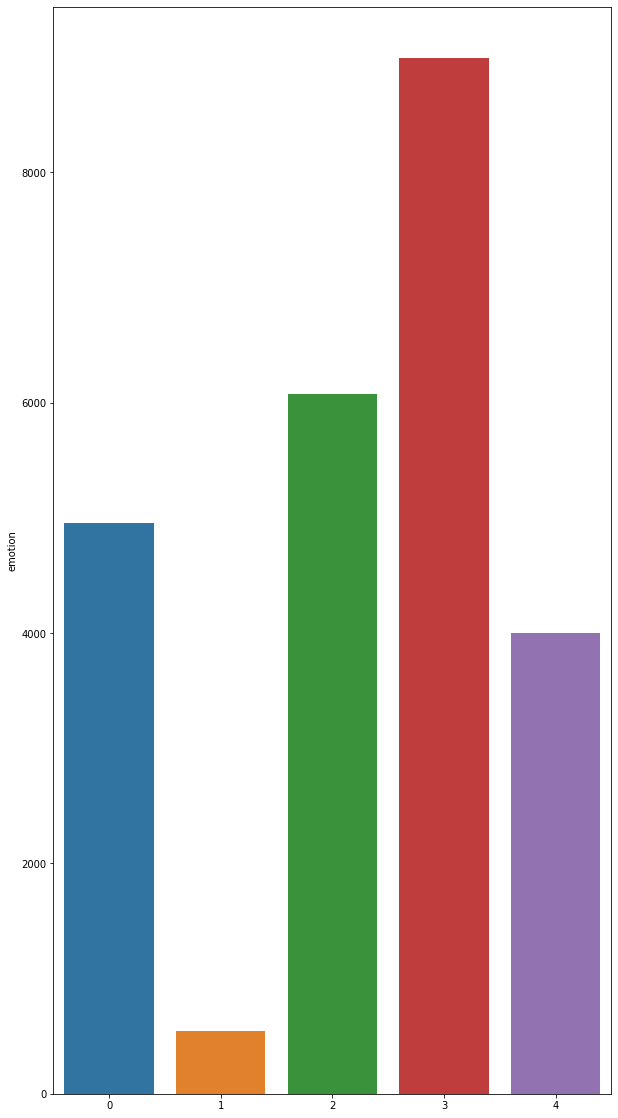

In [62]:
plt.figure(figsize = (10, 20))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

##Perform Data Preparation and Image Augmentation

In [63]:
#split the dataframe in to feature and labels
from keras.utils import to_categorical
X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

In [64]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [65]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [66]:
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96,1)

In [67]:
print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [69]:
#Split the DataFrame in to train, test and validation dataframes
from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [70]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [71]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [72]:
#Image Pre-Processing
X_train = X_train/255
X_val = X_val/255
X_Test = X_Test/255

In [73]:
X_train

array([[[[ 0.13371833],
         [ 0.17781468],
         [ 0.2497038 ],
         ...,
         [ 0.08100723],
         [ 0.07916745],
         [ 0.07801777]],

        [[ 0.15152402],
         [ 0.18956071],
         [ 0.25151524],
         ...,
         [ 0.08090007],
         [ 0.07904412],
         [ 0.07789444]],

        [[ 0.18140168],
         [ 0.20942299],
         [ 0.25496215],
         ...,
         [ 0.08063725],
         [ 0.07878131],
         [ 0.07764779]],

        ...,

        [[ 0.42360857],
         [ 0.42465618],
         [ 0.42683932],
         ...,
         [ 0.04220515],
         [ 0.04223423],
         [ 0.04224877]],

        [[ 0.42381862],
         [ 0.4231882 ],
         [ 0.42224875],
         ...,
         [ 0.04008963],
         [ 0.04009932],
         [ 0.04010417]],

        [[ 0.42389938],
         [ 0.4223932 ],
         [ 0.4197919 ],
         ...,
         [ 0.03880208],
         [ 0.03880208],
         [ 0.03880208]]],


       [[[ 0.10345542],


In [76]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest"
)

## Build and Train Deep Learning Model For Facial Expression Classification

In [77]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [78]:
#train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [80]:
#Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json
#Using early stopping to exit training if validation loss is not decreasing even after certain epochs(patience)
earlystopping = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only= True)

In [84]:
history = model_2_emotion.fit(train_datagen.flow(X_train,y_train, batch_size= 64),
                              validation_data = (X_val, y_val), steps_per_epoch = len(X_train)// 64,
                                                 epochs = 2, callbacks = [checkpointer, earlystopping])

Epoch 1/2
345/345 [==============================] - 443s 1s/step - loss: 1.5842 - accuracy: 0.3916 - val_loss: 1.4453 - val_accuracy: 0.3811

Epoch 00001: val_loss improved from inf to 1.44531, saving model to FacialExpression_weights.hdf5
Epoch 2/2
345/345 [==============================] - 439s 1s/step - loss: 0.9626 - accuracy: 0.6188 - val_loss: 1.2298 - val_accuracy: 0.5098

Epoch 00002: val_loss improved from 1.44531 to 1.22984, saving model to FacialExpression_weights.hdf5


In [85]:
#saving the mdoel architecture to json file for future use
model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json", "w") as json_file:
  json_file.write(model_json)

##Understand How to Assess Classifier Models (Confusion Matrix, Accuracy, Precision, and Recall)
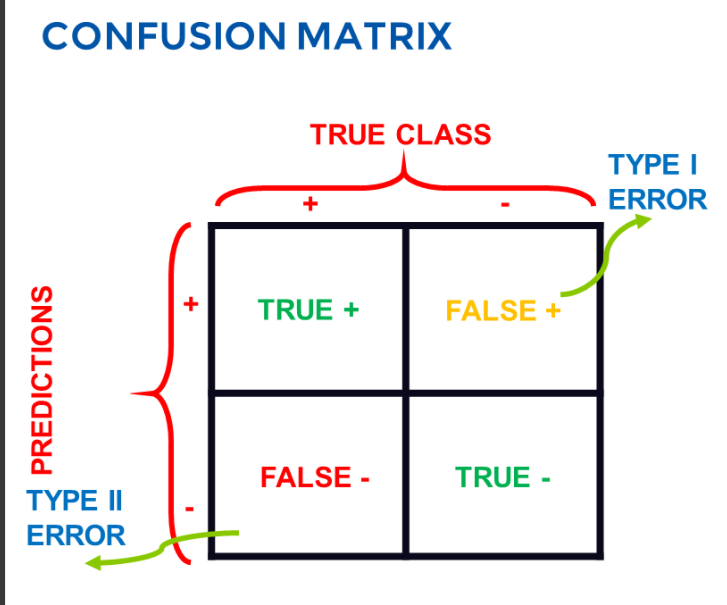

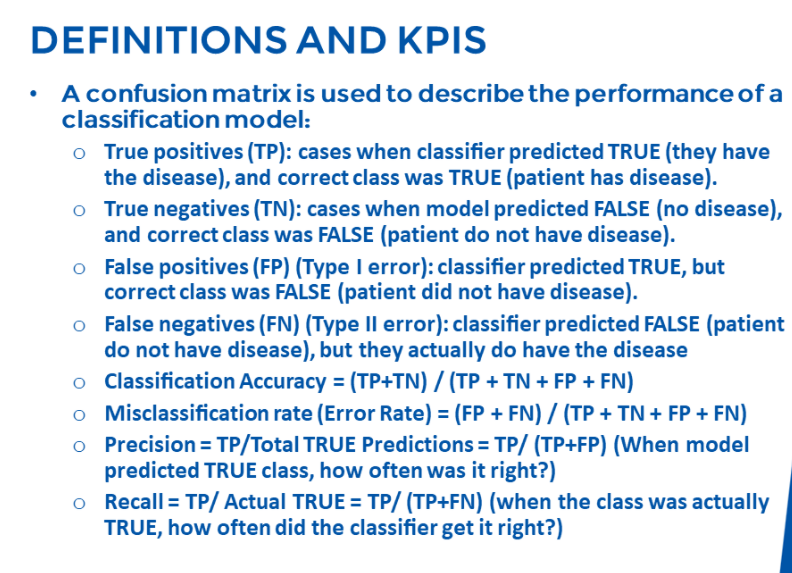

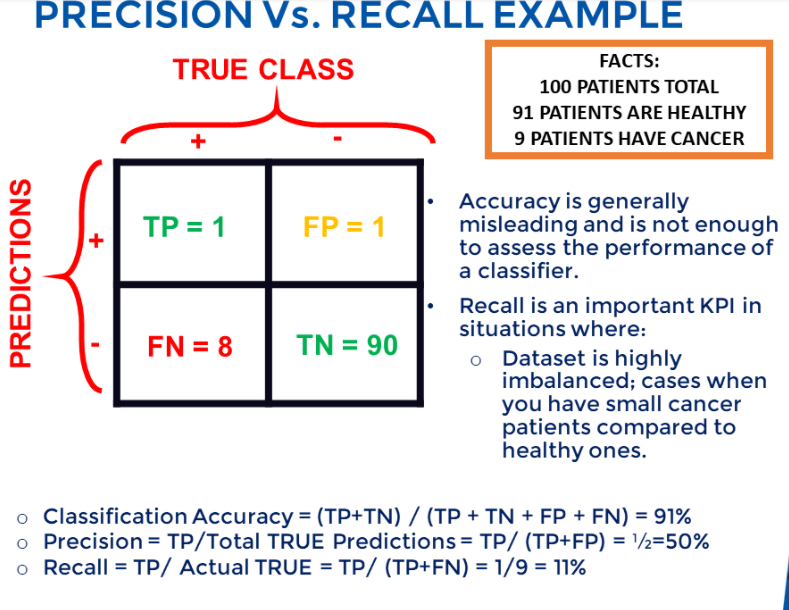

##Assess the Performance of Trained Facial Expression Classifier Model

In [86]:
with open('emotion.json', 'r') as json_file:
  json_savedModel = json_file.read()

#load the model architecture
model_2_emotion = keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [89]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print("Test Accuracy: {}".format(score[1]))

39/39 [==============================] - 6s 138ms/step - loss: 0.3588 - accuracy: 0.8717
Test Accuracy: 0.8706265091896057


In [90]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [91]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

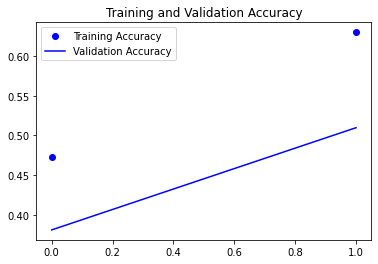

In [92]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

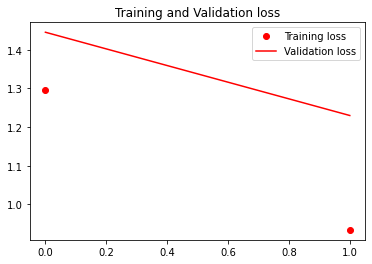

In [93]:
plt.plot(epochs, loss, 'ro', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [94]:
#predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis = -1)
y_true = np.argmax(y_Test, axis = -1)

In [96]:
y_true.shape

(1229,)

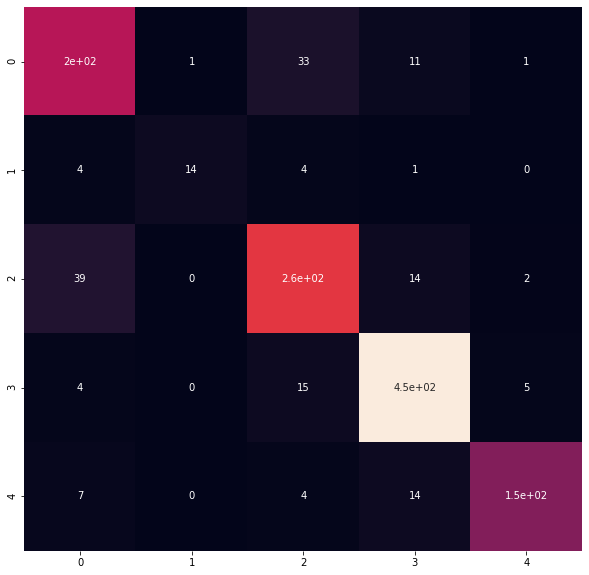

In [95]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, cbar = False)

### Grid of 25 images along with predicted/true label
Classification Report and Precision vs Recall

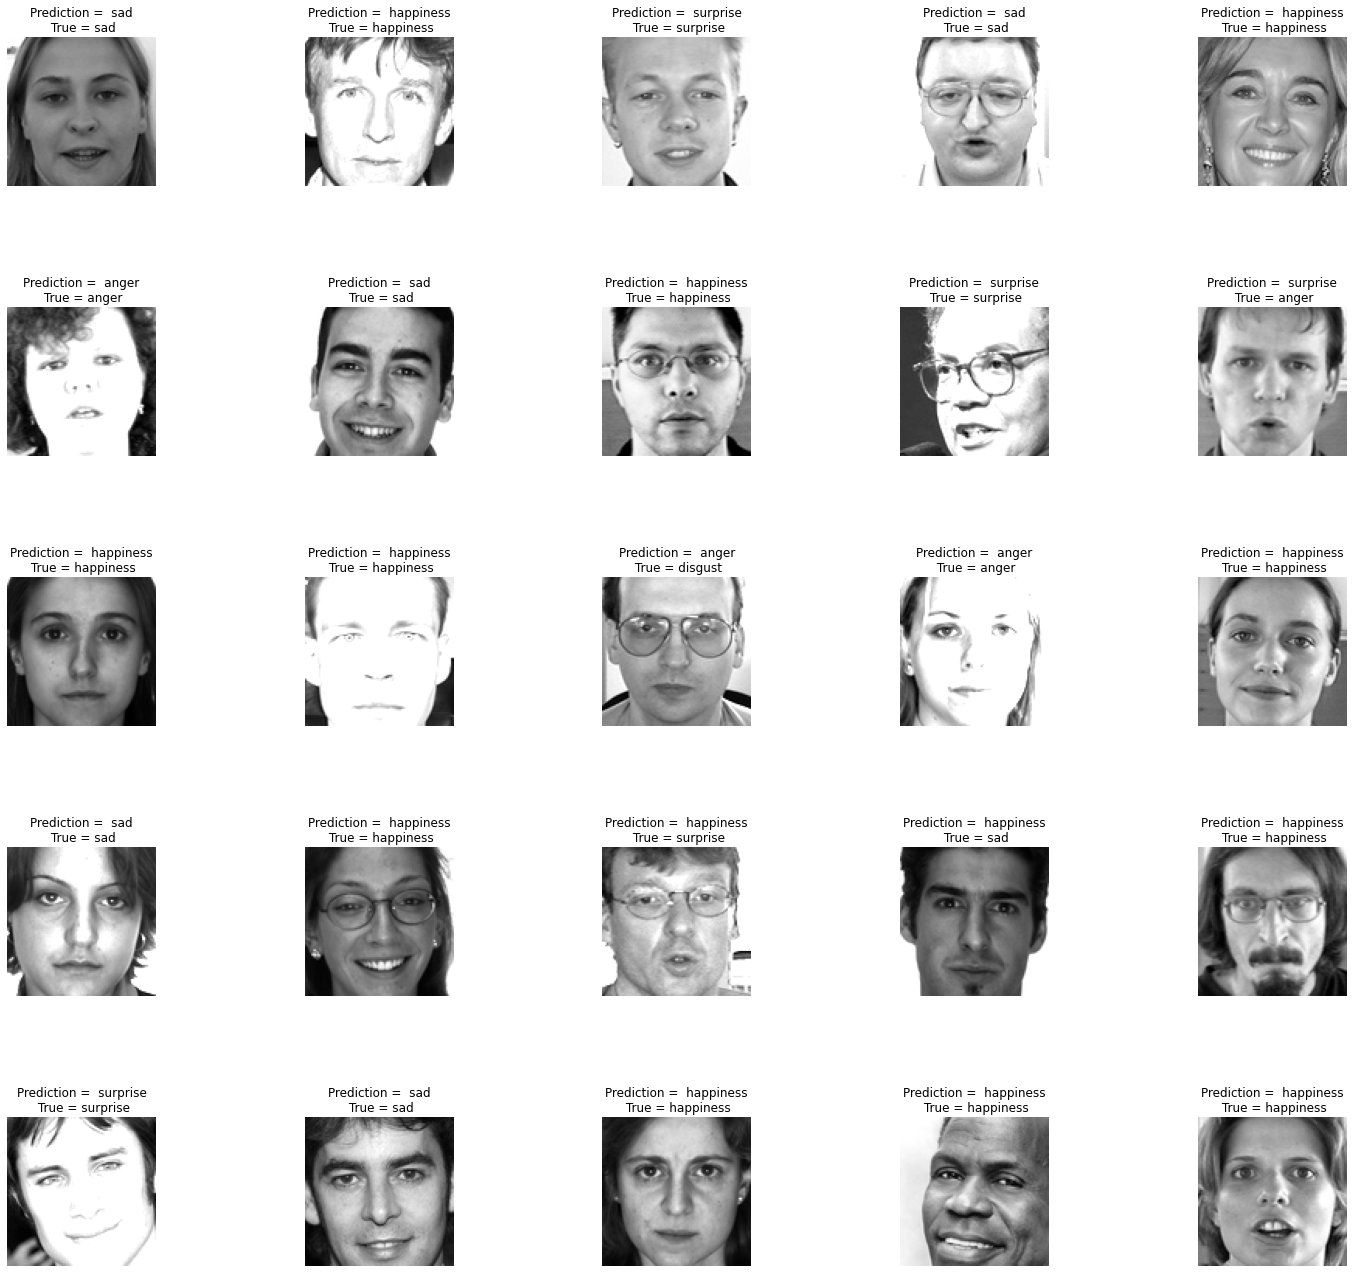

In [97]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24,24))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(X_test[i].reshape(96,96), cmap = "gray")
  axes[i].set_title('Prediction =  {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
  axes[i].axis('off')


plt.subplots_adjust(wspace = 1)

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       248
           1       0.93      0.61      0.74        23
           2       0.82      0.82      0.82       314
           3       0.92      0.95      0.93       471
           4       0.95      0.86      0.90       173

    accuracy                           0.87      1229
   macro avg       0.88      0.81      0.84      1229
weighted avg       0.87      0.87      0.87      1229



#Part 3 Combine BOth Facial Expression And Key Points Detection Models


## Combine Both Models 
- (1) Facial Key Points Detection
- (2) Facial Expression Models

In [99]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [100]:
df_predict = predict(X_test)

In [101]:
df_predict.head()

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  emotion
0          30.683353          39.236336  ...                  85.538094        3
1          66.854500          39.095959  ...                  83.282288        0
2          66.396461          37.163990  ...                  82.585228        3
3          65.076439          37.976490  ...                  79.353485        2
4          30.290146          35.660976  ...                  80.646721        3

[5 rows x 31 columns]

## Plot a Grid of 16 Images along with their Predicted Emotion and Facial Key Points

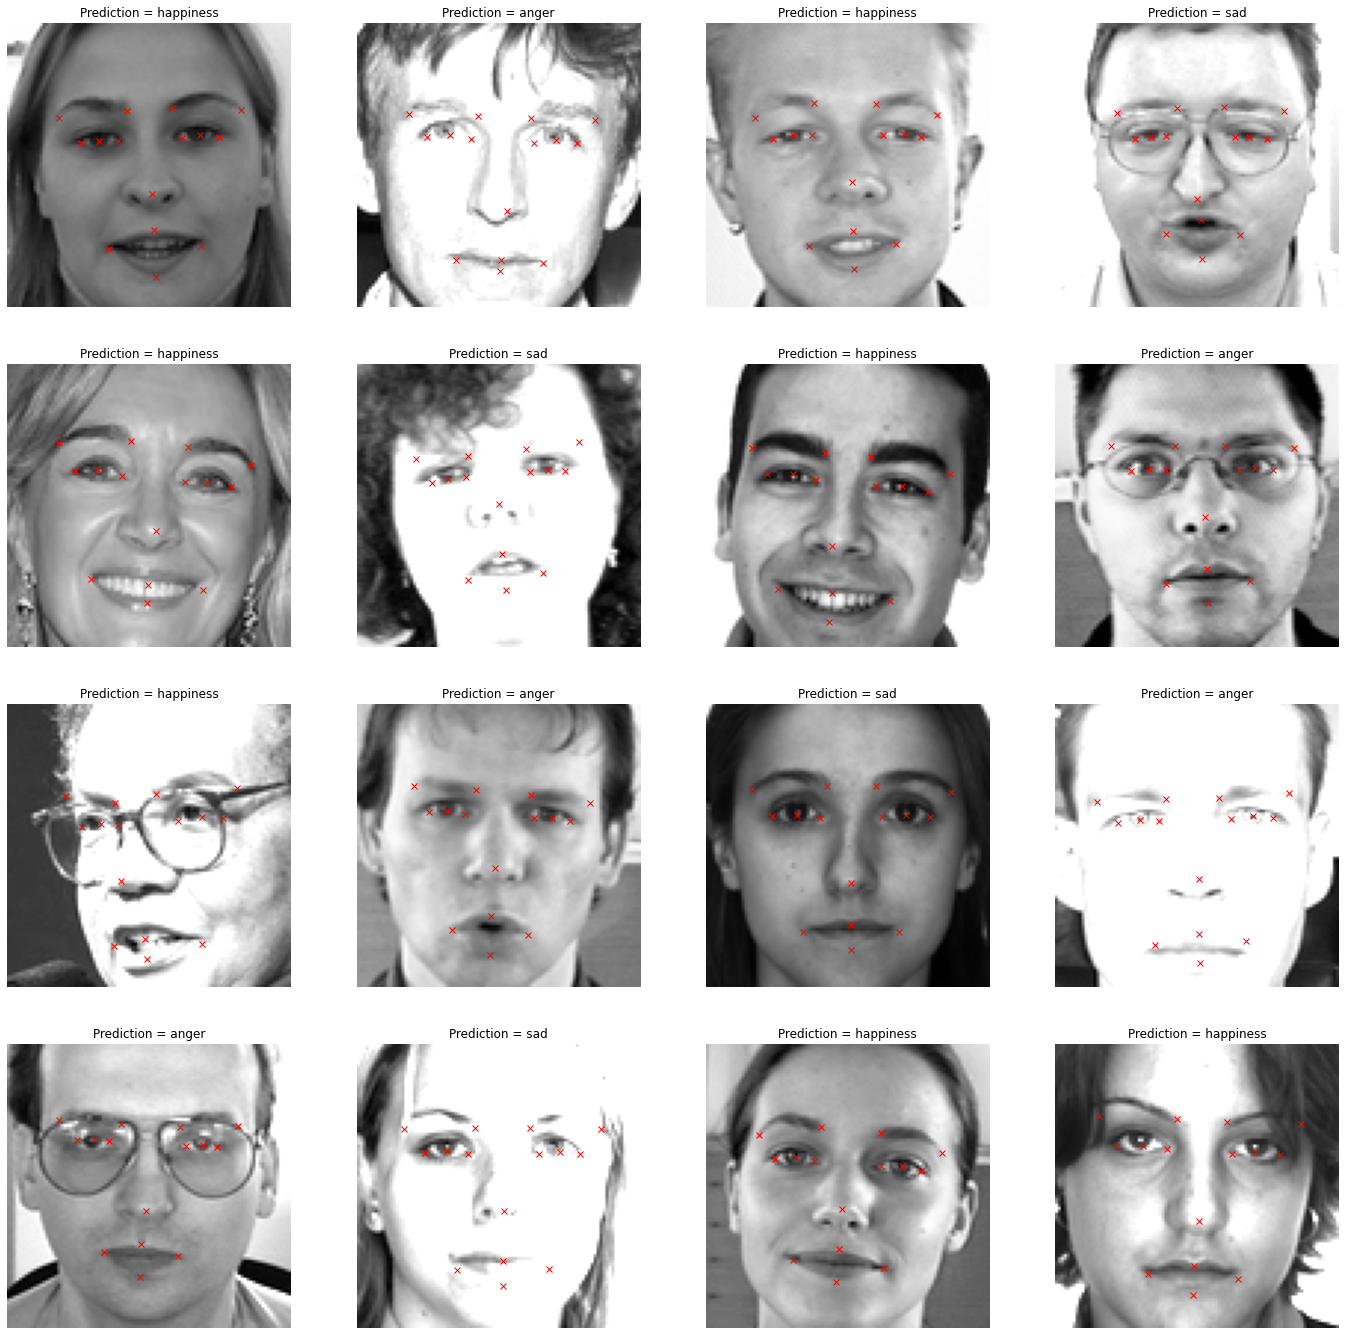

In [102]:
#Plotting the test images and their predicted keypoints and emotions
fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):
  axes[i].imshow(X_test[i].squeeze(), cmap = 'gray')
  axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
  axes[i].axis('off')

  for j in range(1, 31, 2):
    axes[i].plot(df_predict.loc[i][j - 1], df_predict.loc[i][j], 'rx')

# Part 4: Deploy Both Trained Models

## Save the Trained Model For Deployment

### Model Deploymnet using Tensorflow Serving:
 - High-Performance Serving System For Machine Learning Models, designed for Production Environments
 - With the help of Tensorflow Serving, easily deploy new algorithms to make predictions
 - save the model in the format that is suitable for serving using TensorFlow Serving
 - model will have a version number and will be saved in a structured directory
 - After model is saved, use the TensorFlow Serving to start making inference requests using a specific version of our trained model "servable"

### Running TensorFlow Serving:
There are some important parameters:
- rest_api_port: the port use for REST requests
- model_name: Use in URL of REST Requests. Choose any name
- model_base_path: This is the path to the directory model is saved

REST is a revival of HTTP in which http commans have semantic meaning.

### Making Request in TensorFlow Serving:
- To make a Prediction using TensorFlow Serving, need to pass the inference requests (image data) as a JSON object
- Then we use Python Requests Library to Make Post Request to the deployed model, 
-- by passing in the JSON object containing inference requests (image data)
- Get the Prediction from the POST request made to the deployed model and then use argmax function to find the predicted class

- Need to save Trained Model in SavedModel format
- model will have a version number and will be saved in a structured directory
- tf.saved_model.save is a function used to build a saved model that is suitable for serving using TensorFlow Serving
- After the model is saved, use TensorFLow Serving to start making inference requets using a specific version of our trained model "servable"
- Use SavedModel to save and load model - variables, graph , and graph's metadata

In [108]:
import json
import tensorflow.keras.backend as K
import tensorflow as tf

def deploy(directory, model):
  MODEL_DIR = directory
  version = 1 

  # Let's join the temp model directory with our chosen version number 
  # The expected result will be = '\tmp\version number'
  export_path = os.path.join(MODEL_DIR, str(version))
  print('export_path = {}\n'.format(export_path))

  # Let's save the model using saved_model.save
  # If the directory already exists, we will remove it using '!rm' 
  # rm removes each file specified on the command line. 

  if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

  tf.saved_model.save(model, export_path)

  os.environ["MODEL_DIR"] = MODEL_DIR

### Serve the Model Using TensorFlow Serving

In [109]:
# Let's add tensorflow-model-server package to our list of packages 
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hi

In [110]:
# Let's install tensorflow model server
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.4.1).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


### Run TensorFlow Serving
- Load Model and Start Making Inferences (Predictions) Based on it
- Important Parameters:
--  rest_api_port: The port for REST requests
-- model_name: use in URL for REST requests. Choose any name
-- model_base_path: path to the directory where you've saved model

In [111]:
deploy('/model', model_1_facialKeyPoints)

export_path = /model/1

INFO:tensorflow:Assets written to: /model/1/assets


In [112]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4500 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [113]:
!tail server.log

2021-03-22 09:49:48.428559: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-03-22 09:49:48.437874: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2021-03-22 09:49:48.720354: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /model/1
2021-03-22 09:49:48.782628: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 502555 microseconds.
2021-03-22 09:49:48.792933: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model/1/assets.extra/tf_serving_warmup_requests
2021-03-22 09:49:48.793357: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: keypoint_model version: 1}
2021-03-22 09:49:48.795723: I tensorflow_serving/model_servers/server.cc

In [114]:
deploy('/model1', model_2_emotion)

export_path = /model1/1

INFO:tensorflow:Assets written to: /model1/1/assets


In [115]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [116]:
!tail server.log

2021-03-22 09:50:08.240872: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-03-22 09:50:08.250202: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2021-03-22 09:50:08.418829: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /model1/1
2021-03-22 09:50:08.475929: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 372944 microseconds.
2021-03-22 09:50:08.485872: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model1/1/assets.extra/tf_serving_warmup_requests
2021-03-22 09:50:08.486136: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: emotion_model version: 1}
2021-03-22 09:50:08.488440: I tensorflow_serving/model_servers/server.c

### Make Requests to Model in TensorFlow Serving

In [117]:
import json

# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 563], [0.9803921580314636], [0.9882352948188782]]]]}


In [118]:
!pip install -q requests

In [119]:
import requests

# Function to make predictions from deployed models
def response(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post('http://localhost:4500/v1/models/keypoint_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_predict = json.loads(json_response.text)['predictions']
  json_response = requests.post('http://localhost:4000/v1/models/emotion_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)
  
  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict= pd.DataFrame(df_predict, columns = columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [120]:
# making prediction
df_predict = response(data)

In [121]:
df_predict

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  emotion
0          30.683350          39.236332  ...                  85.538094        3
1          66.854485          39.095962  ...                  83.282280        0
2          66.396469          37.163990  ...                  82.585228        3

[3 rows x 31 columns]

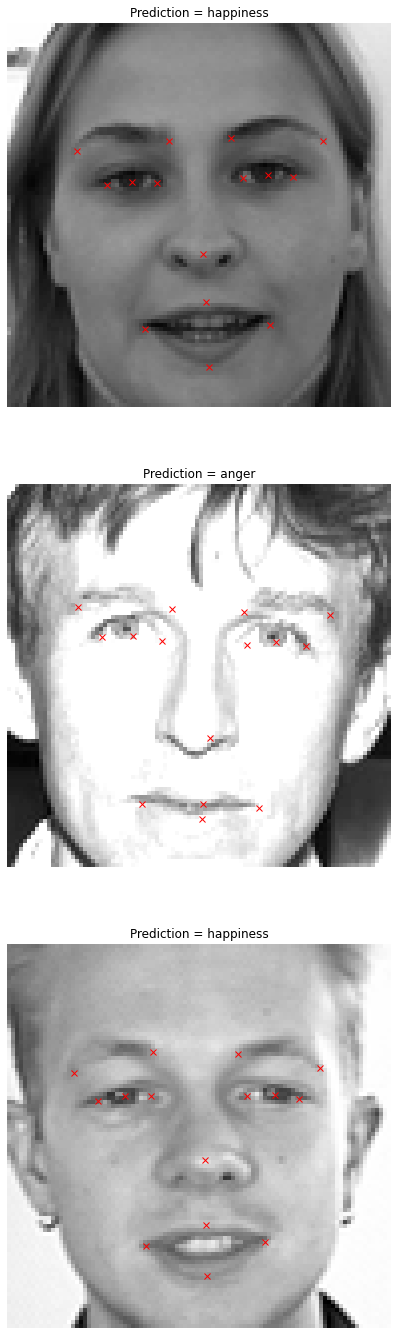

In [122]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(3, 1, figsize = (24, 24))
axes = axes.ravel()

for i in range(3):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            